In [1]:
import torch
import lightning
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import plot_metrics

torch.manual_seed(3)

from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

In [7]:
suffix= '_ca_sc'

n_states = 2
files = [f"D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR{suffix}", f"D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR{suffix}"]

with open(files[1],'r') as f:
    line = f.readline()
feature_names = line.split()[3:]

dataset, df = create_dataset_from_files(files,return_dataframe=True, filter_args={'items': feature_names}, stride=10, dtype='float32')

Class 0 dataframe shape:  (12001, 10014)
Class 1 dataframe shape:  (5001, 10014)

 - Loaded dataframe (17002, 10014): ['time', 'd_CA_1_MET_CENTROID_1_MET', 'd_CA_1_MET_CA_2_GLU', 'd_CA_1_MET_CENTROID_2_GLU', 'd_CA_1_MET_CA_3_TYR', 'd_CA_1_MET_CENTROID_3_TYR', 'd_CA_1_MET_CA_4_GLN', 'd_CA_1_MET_CENTROID_4_GLN', 'd_CA_1_MET_CA_5_HIS', 'd_CA_1_MET_CENTROID_5_HIS', 'd_CA_1_MET_CA_6_TRP', 'd_CA_1_MET_CENTROID_6_TRP', 'd_CA_1_MET_CA_7_LEU', 'd_CA_1_MET_CENTROID_7_LEU', 'd_CA_1_MET_CA_8_ARG', 'd_CA_1_MET_CENTROID_8_ARG', 'd_CA_1_MET_CA_9_GLU', 'd_CA_1_MET_CENTROID_9_GLU', 'd_CA_1_MET_CA_10_ALA', 'd_CA_1_MET_CENTROID_10_ALA', 'd_CA_1_MET_CA_11_ILE', 'd_CA_1_MET_CENTROID_11_ILE', 'd_CA_1_MET_CA_12_SER', 'd_CA_1_MET_CENTROID_12_SER', 'd_CA_1_MET_CA_13_GLN', 'd_CA_1_MET_CENTROID_13_GLN', 'd_CA_1_MET_CA_14_LEU', 'd_CA_1_MET_CENTROID_14_LEU', 'd_CA_1_MET_CA_15_GLN', 'd_CA_1_MET_CENTROID_15_GLN', 'd_CA_1_MET_CA_16_ALA', 'd_CA_1_MET_CENTROID_16_ALA', 'd_CA_1_MET_CA_17_SER', 'd_CA_1_MET_CENTROID_17_SE

In [8]:
# get inputs X and labels
X = dataset[:]['data']
labels = dataset[:]['labels']

print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([17002, 10011])
labels: torch.Size([17002])


In [9]:
# create datamodule for trainer
datamodule = DictModule(dataset,lengths=[0.8,0.2])  # training, validation, test
datamodule

DictModule(dataset -> DictDataset( "data": [17002, 10011], "labels": [17002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

In [10]:
from mlcolvar.cvs import DeepLDA

n_components = n_states-1
nn_layers = [X.shape[1],60,60,60,30,30,5]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
sw_reg = 0.05
# MODEL
model = DeepLDA(nn_layers,n_states=n_states, options=options)
model.set_regularization(sw_reg=sw_reg)

In [11]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name    | Type                  | Params | Mode  | In sizes | Out sizes
------------------------------------

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 100: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s, v_num=183]


Available metrics: dict_keys(['epoch', 'train_loss', 'train_loss_step', 'train_lorentzian_reg', 'train_lorentzian_reg_step', 'train_eigval_1', 'train_eigval_1_step', 'valid_loss', 'valid_loss_epoch', 'valid_lorentzian_reg', 'valid_lorentzian_reg_epoch', 'valid_eigval_1', 'valid_eigval_1_epoch', 'train_loss_epoch', 'train_lorentzian_reg_epoch', 'train_eigval_1_epoch'])


<Axes: title={'center': 'Training and Validation Loss'}, xlabel='Epoch', ylabel='Loss'>

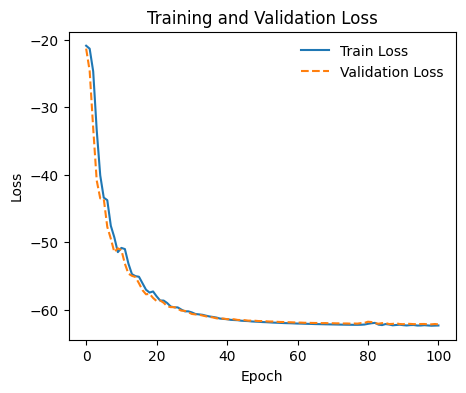

In [12]:
metrics_dict = metrics.metrics  # A dictionary with logged metrics
print("Available metrics:", metrics_dict.keys())

keys = ["train_loss_epoch", "valid_loss_epoch"]

plot_metrics(
    metrics=metrics_dict,
    keys=keys,
    labels=["Train Loss", "Validation Loss"],
    linestyles=["-", "--"],
    xlabel="Epoch",
    ylabel="Loss",
    title="Training and Validation Loss",
)

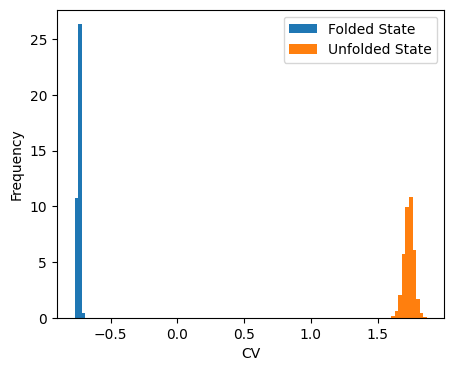

In [ ]:
import numpy as np
'''
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
print(s)
ax.hist(s[:,0],bins=100)
ax.set_xlabel('CV')
ax.set_ylabel('Histogram')
'''
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

folded_cv = s[labels == 0, 0]  # CV for folded state
unfolded_cv = s[labels == 1, 0]  # CV for unfolded state

bins = np.linspace(min(s[:, 0]), max(s[:, 0]), 300)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(folded_cv, density=True, bins=bins, label="Folded State")
ax.hist(unfolded_cv, density=True, bins=bins, label="Unfolded State")
ax.set_xlabel("CV")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

In [ ]:
# Saving the model
example_input = torch.randn(1, 1000)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/deeplda_cvs/model_10011.ptc")